In [3]:
import csv
import ast
import heapq
from collections import defaultdict, deque
from functools import lru_cache
import time
import psutil  
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import json

print("Libraries are loaded 🚀")

Libraries are loaded 🚀


In [4]:
PATHFINDER_DIR = '/workspaces/T-AIA-901_par_1/pathfinder_try/'
with open(PATHFINDER_DIR + 'output/stations_info.json', 'r') as json_file:
    station_data = json.load(json_file)

def convert_to_dict(connected_to_str):
    try:
        list_of_dicts = ast.literal_eval(connected_to_str)
        return {str(item['station']): float("{:.2f}".format(item['distance'])) for item in list_of_dicts}
    except (ValueError, SyntaxError):
        print(f"Error converting data: {connected_to_str}")
        return None

connected_stations = {}
with open(PATHFINDER_DIR + '/output/adjacency_list_stations_uic.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=',')
    for row in reader:
        code_uic = str(row['CODE_UIC'])
        connected_stations[code_uic] = convert_to_dict(row['connected_to'])

print("Data is loaded 🚀")

Data is loaded 🚀


In [5]:
class Graph:
    def __init__(self):
        self.graph = defaultdict(dict)
    
    def add_edge(self, node1, node2, weight):
        self.graph[node1][node2] = weight
        self.graph[node2][node1] = weight
    
    def get_neighbors(self, node):
        return self.graph[node]
    
    def get_all_nodes(self):
        return self.graph.keys()

G = Graph()
for station, connections in connected_stations.items():
    for connected_station, distance in connections.items():
        G.add_edge(station, connected_station, distance)

print(f"Graph has {len(G.get_all_nodes())} nodes and {sum(len(neighbors) for neighbors in G.graph.values())} edges")

Graph has 3352 nodes and 100348 edges


In [6]:
from abc import ABC, abstractmethod

class Pathfinder(ABC):
    def __init__(self, graph):
        self.graph = graph

    @abstractmethod
    def find_route(self, start, goal):
        pass

    def heuristic(self, node1, node2):
        node1_coords = station_data[node1]['coordinates']
        node2_coords = station_data[node2]['coordinates']
        return geodesic(node1_coords, node2_coords).kilometers

    def path_code_to_object(self, path, verbose=False):
        return [station_data[station]['libelle'] if not verbose else station_data[station] for station in path]

    def reconstruct_path(self, came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.insert(0, current)
        return self.path_code_to_object(total_path)

    def monitor_memory(self, process, peak_memory):
        current_memory = process.memory_info().rss
        return max(peak_memory, current_memory)

    def serialize_result(self, came_from, current_node, goal, distance, total_memory, start_time, end_time, tries):
        total_time = end_time - start_time
        average_node_time = total_time / tries if tries > 0 else 0
        memory_usage_mb = total_memory / (1024 ** 2)

        return {
            "path": self.reconstruct_path(came_from, current_node),
            "distance": distance,
            "tries": tries,
            "time": total_time,
            "path_length": len(self.reconstruct_path(came_from, goal)),
            "memory_usage": round(memory_usage_mb, 6),
            "max_memory_usage": psutil.virtual_memory().used / (1024 ** 2),
            "explored_nodes": tries,
            "average_node_time": average_node_time
        }


In [7]:

class AStar(Pathfinder):
    def find_route(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        open_set = [(0, start)]
        came_from = {}
        g_score = {node: float('inf') for node in self.graph.get_all_nodes()}
        g_score[start] = 0
        f_score = {node: float('inf') for node in self.graph.get_all_nodes()}
        f_score[start] = self.heuristic(start, goal)
        tries = 0
        visited_nodes = set()
        
        while open_set:
            tries += 1
            current_f, current_node = heapq.heappop(open_set)
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, g_score[goal], total_memory, start_time, end_time, tries)

            for neighbor, distance in self.graph.get_neighbors(current_node).items():
                tentative_g_score = g_score[current_node] + distance
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current_node
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        return None


In [8]:
class Dijkstra(Pathfinder):
    def find_route(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        pq = [(0, start)]
        distances = {node: float('inf') for node in self.graph.get_all_nodes()}
        distances[start] = 0
        came_from = {}
        tries = 0
        visited_nodes = set()
        
        while pq:
            tries += 1
            current_distance, current_node = heapq.heappop(pq)
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, distances[goal], total_memory, start_time, end_time, tries)

            for neighbor, distance in self.graph.get_neighbors(current_node).items():
                tentative_distance = current_distance + distance
                if tentative_distance < distances[neighbor]:
                    distances[neighbor] = tentative_distance
                    came_from[neighbor] = current_node
                    heapq.heappush(pq, (tentative_distance, neighbor))
        return None

In [9]:
class BellmanFord(Pathfinder):
    def find_route(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory

        start_time = time.time()
        distances = {node: float('inf') for node in self.graph.get_all_nodes()}
        distances[start] = 0
        came_from = {}
        tries = 0

        for _ in range(len(self.graph.get_all_nodes()) - 1):
            tries += 1
            for node in self.graph.get_all_nodes():
                for neighbor, distance in self.graph.get_neighbors(node).items():
                    if distances[node] + distance < distances[neighbor]:
                        distances[neighbor] = distances[node] + distance
                        came_from[neighbor] = node

            peak_memory = self.monitor_memory(process, peak_memory)

        for node in self.graph.get_all_nodes():
            for neighbor, distance in self.graph.get_neighbors(node).items():
                if distances[node] + distance < distances[neighbor]:
                    return {"error": "Negative-weight cycle detected"}

        end_time = time.time()
        total_memory = peak_memory - start_memory
        return self.serialize_result(came_from, goal, goal, distances[goal], total_memory, start_time, end_time, tries)

In [10]:
class BFS(Pathfinder):
    def find_route(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        queue = deque([start])
        came_from = {}
        visited = {node: False for node in self.graph.get_all_nodes()}
        visited[start] = True
        tries = 0
        visited_nodes = set([start])
        
        while queue:
            tries += 1
            current_node = queue.popleft()

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

            for neighbor in self.graph.get_neighbors(current_node):
                if not visited[neighbor]:
                    visited[neighbor] = True
                    came_from[neighbor] = current_node
                    queue.append(neighbor)
                    visited_nodes.add(neighbor)
                    
        return None

In [11]:
class DFS(Pathfinder):
    def find_route(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory

        start_time = time.time()
        stack = [(start, [start])]
        came_from = {}
        visited_nodes = set()
        tries = 0

        while stack:
            tries += 1
            current_node, path = stack.pop()
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)

            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

            for neighbor in self.graph.get_neighbors(current_node):
                if neighbor not in visited_nodes:
                    came_from[neighbor] = current_node
                    stack.append((neighbor, path + [neighbor]))

        return None


In [10]:
## VIUX CODE A SUPPRIMER

# class Pathfinder:
#     def __init__(self, graph):
#         self.graph = graph
    
#     @lru_cache(maxsize=None)
#     def heuristic(self, node1, node2):
#         node1_coords = station_data[node1]['coordinates']
#         node2_coords = station_data[node2]['coordinates']
#         return geodesic(node1_coords, node2_coords).kilometers

#     def path_code_to_object(self, path, verbose=False):
#         return [station_data[station]['libelle'] if not verbose else station_data[station] for station in path]

#     def reconstruct_path(self, came_from, current):
#         total_path = [current]
#         while current in came_from:
#             current = came_from[current]
#             total_path.insert(0, current)
#         return self.path_code_to_object(total_path)

#     def monitor_memory(self, process, peak_memory):
#         current_memory = process.memory_info().rss
#         return max(peak_memory, current_memory)

#     def serialize_result(self, came_from, current_node, goal, distance, total_memory, start_time, end_time, tries):
#         total_time = end_time - start_time
#         average_node_time = total_time / tries if tries > 0 else 0
#         memory_usage_mb = total_memory / (1024 ** 2) 

#         return {
#             "path": self.reconstruct_path(came_from, current_node),
#             "distance": distance,
#             "tries": tries,
#             "time": total_time,
#             "path_length": len(self.reconstruct_path(came_from, goal)),
#             "memory_usage": round(memory_usage_mb, 6), 
#             "max_memory_usage": psutil.virtual_memory().used / (1024 ** 2), 
#             "explored_nodes": tries,
#             "average_node_time": average_node_time
#         }

#     def a_star(self, start, goal):
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         peak_memory = start_memory
        
#         start_time = time.time()
#         open_set = [(0, start)]
#         came_from = {}
#         g_score = {node: float('inf') for node in self.graph.get_all_nodes()}
#         g_score[start] = 0
#         f_score = {node: float('inf') for node in self.graph.get_all_nodes()}
#         f_score[start] = self.heuristic(start, goal)
#         tries = 0
#         visited_nodes = set()
        
#         while open_set:
#             tries += 1
#             current_f, current_node = heapq.heappop(open_set)
#             visited_nodes.add(current_node)

#             peak_memory = self.monitor_memory(process, peak_memory)
            
#             if current_node == goal:
#                 end_time = time.time()
#                 total_memory = peak_memory - start_memory
#                 return self.serialize_result(came_from, current_node, goal, g_score[goal], total_memory, start_time, end_time, tries)

#             for neighbor, distance in self.graph.get_neighbors(current_node).items():
#                 tentative_g_score = g_score[current_node] + distance
#                 if tentative_g_score < g_score[neighbor]:
#                     came_from[neighbor] = current_node
#                     g_score[neighbor] = tentative_g_score
#                     f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, goal)
#                     heapq.heappush(open_set, (f_score[neighbor], neighbor))
#         return None

#     def dijkstra(self, start, goal):
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         peak_memory = start_memory
        
#         start_time = time.time()
#         pq = [(0, start)]
#         distances = {node: float('inf') for node in self.graph.get_all_nodes()}
#         distances[start] = 0
#         came_from = {}
#         tries = 0
#         visited_nodes = set()
        
#         while pq:
#             tries += 1
#             current_distance, current_node = heapq.heappop(pq)
#             visited_nodes.add(current_node)

#             peak_memory = self.monitor_memory(process, peak_memory)
            
#             if current_node == goal:
#                 end_time = time.time()
#                 total_memory = peak_memory - start_memory
#                 return self.serialize_result(came_from, current_node, goal, distances[goal], total_memory, start_time, end_time, tries)

#             for neighbor, distance in self.graph.get_neighbors(current_node).items():
#                 tentative_distance = current_distance + distance
#                 if tentative_distance < distances[neighbor]:
#                     distances[neighbor] = tentative_distance
#                     came_from[neighbor] = current_node
#                     heapq.heappush(pq, (tentative_distance, neighbor))
#         return None

#     def bfs(self, start, goal):
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         peak_memory = start_memory
        
#         start_time = time.time()
#         queue = deque([start])
#         came_from = {}
#         visited = {node: False for node in self.graph.get_all_nodes()}
#         visited[start] = True
#         tries = 0
#         visited_nodes = set([start])
        
#         while queue:
#             tries += 1
#             current_node = queue.popleft()

#             peak_memory = self.monitor_memory(process, peak_memory)
            
#             if current_node == goal:
#                 end_time = time.time()
#                 total_memory = peak_memory - start_memory
#                 return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

#             for neighbor in self.graph.get_neighbors(current_node):
#                 if not visited[neighbor]:
#                     visited[neighbor] = True
#                     came_from[neighbor] = current_node
#                     queue.append(neighbor)
#                     visited_nodes.add(neighbor)
#         return None

#     def bellman_ford(self, start, goal):
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         peak_memory = start_memory

#         start_time = time.time()
#         distances = {node: float('inf') for node in self.graph.get_all_nodes()}
#         distances[start] = 0
#         came_from = {}
#         tries = 0

#         for _ in range(len(self.graph.get_all_nodes()) - 1):
#             tries += 1
#             for node in self.graph.get_all_nodes():
#                 for neighbor, distance in self.graph.get_neighbors(node).items():
#                     if distances[node] + distance < distances[neighbor]:
#                         distances[neighbor] = distances[node] + distance
#                         came_from[neighbor] = node

#             peak_memory = self.monitor_memory(process, peak_memory)

#         for node in self.graph.get_all_nodes():
#             for neighbor, distance in self.graph.get_neighbors(node).items():
#                 if distances[node] + distance < distances[neighbor]:
#                     return {"error": "Negative-weight cycle detected"}

#         end_time = time.time()
#         total_memory = peak_memory - start_memory
#         return self.serialize_result(came_from, goal, goal, distances[goal], total_memory, start_time, end_time, tries)

#     def dfs(self, start, goal):
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         peak_memory = start_memory

#         start_time = time.time()
#         stack = [(start, [start])]
#         came_from = {}
#         visited_nodes = set()
#         tries = 0

#         while stack:
#             tries += 1
#             (current_node, path) = stack.pop()
#             visited_nodes.add(current_node)

#             peak_memory = self.monitor_memory(process, peak_memory)

#             if current_node == goal:
#                 end_time = time.time()
#                 total_memory = peak_memory - start_memory
#                 return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

#             for neighbor in self.graph.get_neighbors(current_node):
#                 if neighbor not in visited_nodes:
#                     came_from[neighbor] = current_node
#                     stack.append((neighbor, path + [neighbor]))

#         return None

Results for A*:
  Path: La Douzillère -> Joué-lès-Tours -> Bressuire -> Chalonnes
  Distance: 166.46999999999997 km
  Tries: 13
  Time: 0.006660 seconds
  Path Length: 4 nodes
  Memory Usage: 0.000000 MB
  Max Memory Usage: 6431.480469 MB
  Explored Nodes: 13
  Average Time per Node: 5.123432e-04 seconds

Results for Dijkstra:
  Path: La Douzillère -> Joué-lès-Tours -> Bressuire -> Chalonnes
  Distance: 166.46999999999997 km
  Tries: 55
  Time: 0.001528 seconds
  Path Length: 4 nodes
  Memory Usage: 0.000000 MB
  Max Memory Usage: 6431.480469 MB
  Explored Nodes: 55
  Average Time per Node: 2.778660e-05 seconds

Results for BFS:
  Path: La Douzillère -> Joué-lès-Tours -> Bressuire -> Chalonnes
  Distance: -1 km
  Tries: 51
  Time: 0.000964 seconds
  Path Length: 4 nodes
  Memory Usage: 0.000000 MB
  Max Memory Usage: 6431.480469 MB
  Explored Nodes: 51
  Average Time per Node: 1.889584e-05 seconds

Results for DFS:
  Path: La Douzillère -> Châtillon-sur-Indre -> Buzançais -> Reignac ->

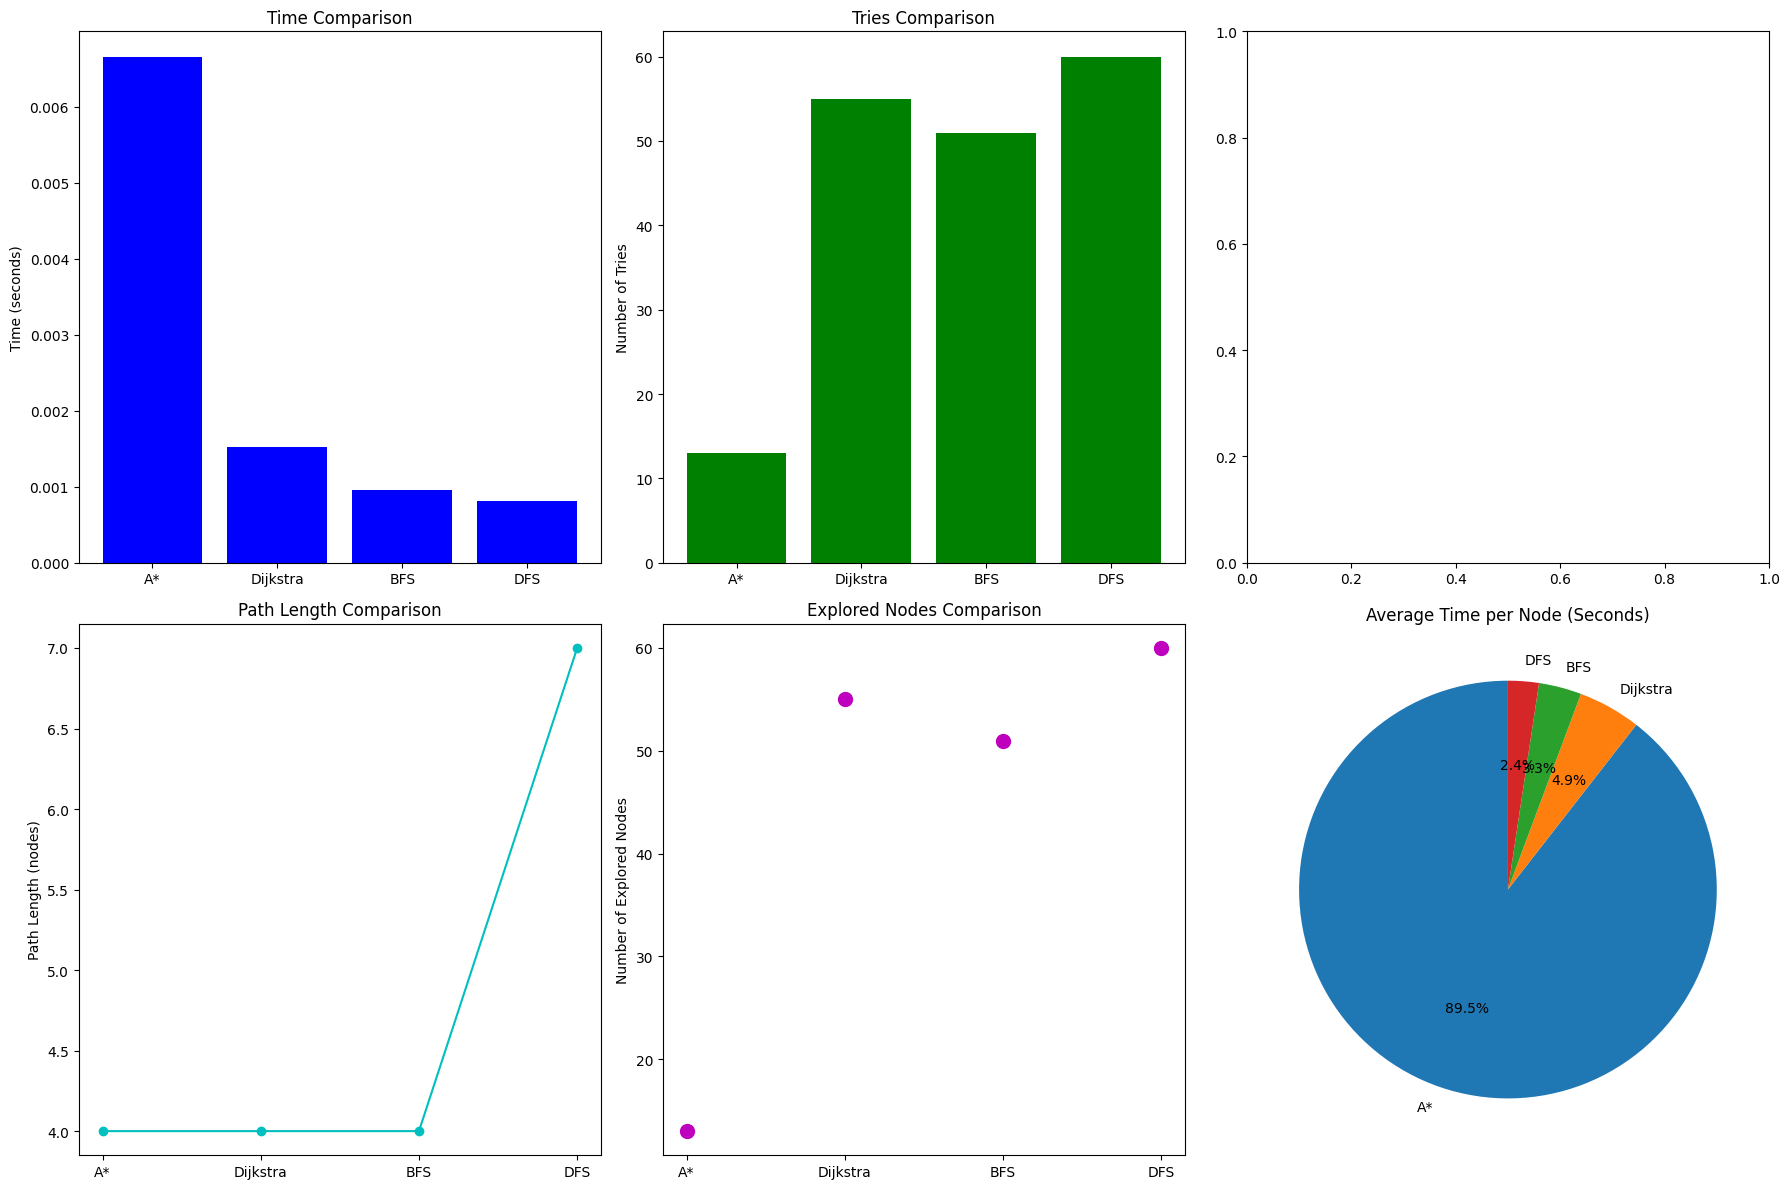

In [17]:
start_station = '87009696'
goal_station = '87484204'

def formatted_print_results(result, algorithm_name):
    print(f"Results for {algorithm_name}:")
    print(f"  Path: {' -> '.join(result['path'])}")
    print(f"  Distance: {result['distance']} km")
    print(f"  Tries: {result['tries']}")
    print(f"  Time: {result['time']:.6f} seconds")
    print(f"  Path Length: {result['path_length']} nodes")
    print(f"  Memory Usage: {result['memory_usage']:.6f} MB")
    print(f"  Max Memory Usage: {result['max_memory_usage']:.6f} MB")
    print(f"  Explored Nodes: {result['explored_nodes']}")
    print(f"  Average Time per Node: {result['average_node_time']:.6e} seconds\n")

a_star_pathfinder = AStar(G)
dijkstra_pathfinder = Dijkstra(G)
bfs_pathfinder = BFS(G)
dfs_pathfinder = DFS(G)
# bellman_ford_pathfinder = BellmanFord(G)  

a_star_result = a_star_pathfinder.find_route(start_station, goal_station)
formatted_print_results(a_star_result, "A*")

dijkstra_result = dijkstra_pathfinder.find_route(start_station, goal_station)
formatted_print_results(dijkstra_result, "Dijkstra")

bfs_result = bfs_pathfinder.find_route(start_station, goal_station)
formatted_print_results(bfs_result, "BFS")

# bellman_ford_result = bellman_ford_pathfinder.find_route(start_station, goal_station)
# formatted_print_results(bellman_ford_result, "Bellman-Ford")

dfs_result = dfs_pathfinder.find_route(start_station, goal_station)
formatted_print_results(dfs_result, "DFS")

def plot_results(results):
    algorithms = list(results.keys())
    times = [results[algo]['time'] for algo in algorithms]
    tries = [results[algo]['tries'] for algo in algorithms]
    # memory_usages = [results[algo]['memory_usage'] for algo in algorithms]
    path_lengths = [results[algo]['path_length'] for algo in algorithms]
    explored_nodes = [results[algo]['explored_nodes'] for algo in algorithms]
    avg_node_times = [results[algo]['average_node_time'] for algo in algorithms]

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    axs[0, 0].bar(algorithms, times, color='b')
    axs[0, 0].set_title('Time Comparison')
    axs[0, 0].set_ylabel('Time (seconds)')

    axs[0, 1].bar(algorithms, tries, color='g')
    axs[0, 1].set_title('Tries Comparison')
    axs[0, 1].set_ylabel('Number of Tries')

    # axs[0, 2].bar(algorithms, memory_usages, color='r')
    # axs[0, 2].set_title('Memory Usage Comparison')
    # axs[0, 2].set_ylabel('Memory Usage (MB)')

    axs[1, 0].plot(algorithms, path_lengths, marker='o', linestyle='-', color='c')
    axs[1, 0].set_title('Path Length Comparison')
    axs[1, 0].set_ylabel('Path Length (nodes)')

    axs[1, 1].scatter(algorithms, explored_nodes, color='m', s=100)
    axs[1, 1].set_title('Explored Nodes Comparison')
    axs[1, 1].set_ylabel('Number of Explored Nodes')

    axs[1, 2].pie(avg_node_times, labels=algorithms, autopct='%1.1f%%', startangle=90)
    axs[1, 2].set_title('Average Time per Node (Seconds)')

    plt.tight_layout()
    plt.savefig("algorithm_comparison.png")
    plt.show()

results = {
    "A*": a_star_result,
    "Dijkstra": dijkstra_result,
    "BFS": bfs_result,
    "DFS": dfs_result
    # "Bellman-Ford": bellman_ford_result,  
}

plot_results(results)

